# Create the initial object classification RF model

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np

In [7]:
quas_data = pd.read_csv('/path/to/Quasar_ugriz.csv', skiprows=1)
star_data = pd.read_csv('/path/to/Star_ugriz.csv', skiprows=1)
gal_data = pd.read_csv('/path/to/Galaxy_ugriz.csv', skiprows=1)

In [8]:
star_data.head()

,objid,modelmag_u,modelmag_g,modelmag_r,modelmag_i,modelmag_z,z,weight
0,1237650795682726190,19.36548,18.94647,19.04925,19.21883,19.35806,0.000111,0.000075
1,1237648722289295504,20.36442,18.21354,17.38881,17.11562,17.32000,0.000178,0.000009
2,1237648721752424633,19.31302,18.13527,17.67289,17.49996,17.44187,0.000213,0.000013
3,1237648721752424612,24.85999,20.76403,19.18368,17.93489,17.28289,0.000066,0.000024
4,1237651752921595910,18.32052,17.01957,16.47373,16.26664,16.14915,0.000286,0.000010


In [10]:
star_data = star_data.where(star_data > -5000)
star_data = star_data.dropna()

gal_data = gal_data.where(gal_data > -5000)
gal_data = gal_data.dropna()

quas_data = quas_data.where(quas_data > -5000)
quas_data = quas_data.dropna()

Label the data by object: qso:2, gal:1, star:0

In [22]:
lbls = [2] * len(quas_data.objid)
quas_data['class'] = lbls

lbls = [1] * len(gal_data.objid)
gal_data['class'] = lbls

lbls = [0] * len(star_data.objid)
star_data['class'] = lbls

In [23]:
all_class = pd.concat([star_data, gal_data, quas_data])
all_class.head()

,objid,modelmag_u,modelmag_g,modelmag_r,modelmag_i,modelmag_z,z,weight,class
0,1237650795682726190,19.36548,18.94647,19.04925,19.21883,19.35806,0.000111,0.000075,0
1,1237648722289295504,20.36442,18.21354,17.38881,17.11562,17.32000,0.000178,0.000009,0
2,1237648721752424633,19.31302,18.13527,17.67289,17.49996,17.44187,0.000213,0.000013,0
3,1237648721752424612,24.85999,20.76403,19.18368,17.93489,17.28289,0.000066,0.000024,0
4,1237651752921595910,18.32052,17.01957,16.47373,16.26664,16.14915,0.000286,0.000010,0


In [24]:
all_class.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1499877 entries, 0 to 499999
Data columns (total 9 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   objid       1499877 non-null  int64  
 1   modelmag_u  1499877 non-null  float64
 2   modelmag_g  1499877 non-null  float64
 3   modelmag_r  1499877 non-null  float64
 4   modelmag_i  1499877 non-null  float64
 5   modelmag_z  1499877 non-null  float64
 6   z           1499877 non-null  float64
 7   weight      1499877 non-null  float64
 8   class       1499877 non-null  int64  
dtypes: float64(7), int64(2)
memory usage: 114.4 MB


In [27]:
all_class.columns[1:6]

Index(['modelmag_u', 'modelmag_g', 'modelmag_r', 'modelmag_i', 'modelmag_z'], dtype='object')

Conduct train test split twice to get training, validation, and testing sets

In [28]:
from sklearn.model_selection import train_test_split

X = all_class[all_class.columns[1:6]]
y = all_class['class'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, shuffle = True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size = 0.85, shuffle = True)

Define random forest classifier as function that reutrns classifier params and accuracy score <br>
Format taken from Dr. Crosby's DATA 507 class.

In [29]:
from sklearn.ensemble import RandomForestClassifier

def rf(X_train, y_train, X_test, y_test, n_estimators):

    # Train the svm 
    clf = RandomForestClassifier(n_estimators=n_estimators, random_state=37)
    
    clf = clf.fit(X_train, y_train)

    # Run the test set
    test_score = clf.score(X_test, y_test)    

    return clf, test_score

In [143]:
rf_acc = []
for n in range(15, 20):
    n_estimators = n
    rf_acc.append(rf(X_train, y_train, X_val, y_val,
                     n_estimators)[1])

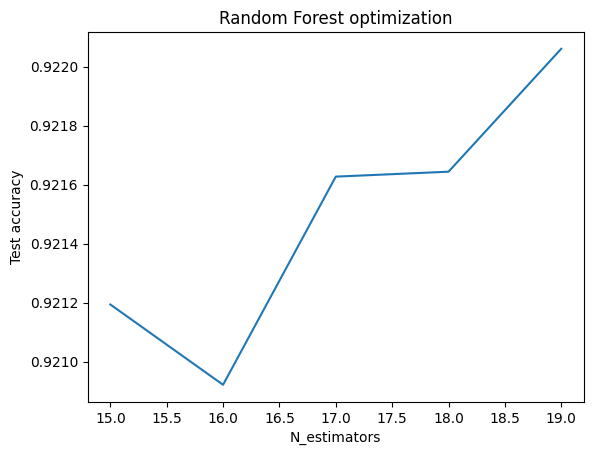

In [144]:
plt.plot(range(15,20), rf_acc)
plt.title('Random Forest optimization')
plt.xlabel('N_estimators')
plt.ylabel('Test accuracy')
plt.show()

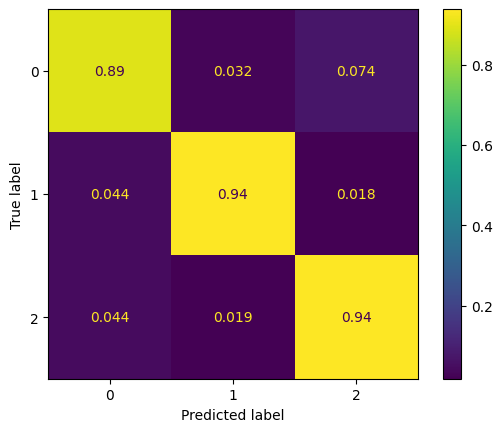

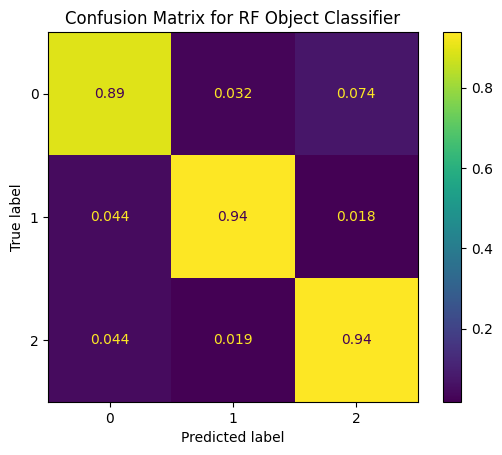

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay
X_train = pd.concat([X_train, X_val])
y_train = pd.concat([y_train, y_val])
#clf = rf(X_train, y_train, X_test, y_test, n_estimators= 19)[0]
y_pred = clf.predict(X_test)
vis = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true')
vis.plot()
plt.title('Confusion Matrix for RF Object Classifier')
plt.show()

# Build anomaly detect model

Load the outlier and inlier data

In [177]:
out_data = pd.read_csv('path/to/gal_out.csv', skiprows=1)
no_sent = out_data.where(out_data > -9990)
no_sent['u-g'] = no_sent['modelmag_u']-no_sent['modelmag_g']
no_sent['g-r'] = no_sent['modelmag_g']-no_sent['modelmag_r']
no_sent['r-i'] = no_sent['modelmag_r']-no_sent['modelmag_i']
no_sent['i-z'] = no_sent['modelmag_i']-no_sent['modelmag_z']
no_sent['outlier'] = 1

In [178]:
no_sent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4059 entries, 0 to 4058
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   objid       4059 non-null   int64  
 1   modelmag_u  4058 non-null   float64
 2   modelmag_g  4058 non-null   float64
 3   modelmag_r  4058 non-null   float64
 4   modelmag_i  4058 non-null   float64
 5   modelmag_z  4058 non-null   float64
 6   z           4059 non-null   float64
 7   weight      4059 non-null   float64
 8   u-g         4058 non-null   float64
 9   g-r         4058 non-null   float64
 10  r-i         4058 non-null   float64
 11  i-z         4058 non-null   float64
 12  outlier     4059 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 412.4 KB


In [179]:
in_data = pd.read_csv('path/to/gal_in.csv', skiprows=1)
no_sent2 = in_data.where(in_data > -9990)
no_sent2['u-g'] = no_sent2['modelmag_u']-no_sent2['modelmag_g']
no_sent2['g-r'] = no_sent2['modelmag_g']-no_sent2['modelmag_r']
no_sent2['r-i'] = no_sent2['modelmag_r']-no_sent2['modelmag_i']
no_sent2['i-z'] = no_sent2['modelmag_i']-no_sent2['modelmag_z']
no_sent2['outlier'] = 0

In [180]:
no_sent2 = no_sent2[:4059]

In [169]:
no_sent2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27682 entries, 0 to 27681
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   objid       27682 non-null  int64  
 1   modelmag_u  27671 non-null  float64
 2   modelmag_g  27671 non-null  float64
 3   modelmag_r  27672 non-null  float64
 4   modelmag_i  27672 non-null  float64
 5   modelmag_z  27672 non-null  float64
 6   z           27682 non-null  float64
 7   weight      27682 non-null  float64
 8   u-g         27671 non-null  float64
 9   g-r         27671 non-null  float64
 10  r-i         27672 non-null  float64
 11  i-z         27672 non-null  float64
 12  outlier     27682 non-null  int64  
dtypes: float64(11), int64(2)
memory usage: 2.7 MB


Join the low error and high error datasets

In [181]:
all_dat = pd.concat([no_sent, no_sent2])
all_dat.head()

,objid,modelmag_u,modelmag_g,modelmag_r,modelmag_i,modelmag_z,z,weight,u-g,g-r,r-i,i-z,outlier
0,1237648722834162463,24.07606,23.42181,22.13659,21.07804,20.66076,0.985896,5.754321,0.65425,1.28522,1.05855,0.41728,1
1,1237651298184397120,19.30869,18.88623,18.76282,18.78697,18.95772,0.241220,1.012593,0.42246,0.12341,-0.02415,-0.17075,1
2,1237679167159075093,27.06569,21.12909,19.33625,18.50272,17.98661,0.996452,7.798197,5.93660,1.79284,0.83353,0.51611,1
3,1237651752409301587,23.69242,21.08363,20.53476,20.28356,19.82209,0.741997,0.538113,2.60879,0.54887,0.25120,0.46147,1
4,1237648705130856994,19.55005,19.45104,19.55948,19.68855,19.80340,0.584357,1.361758,0.09901,-0.10844,-0.12907,-0.11485,1


In [149]:
no_sent2['weight'].quantile(.98)

0.002170116339999998

In [150]:
from sklearn.ensemble import RandomForestClassifier

def rf(X_train, y_train, X_test, y_test, n_estimators):

    # Train the svm 
    clf = RandomForestClassifier(n_estimators=n_estimators, random_state=37)
    
    clf = clf.fit(X_train, y_train)

    # Run the test set
    test_score = clf.score(X_test, y_test)    

    return clf, test_score

In [22]:
no_sent.columns

Index(['objid', 'modelmag_u', 'modelmag_g', 'modelmag_r', 'modelmag_i',
       'modelmag_z', 'z', 'weight', 'u-g', 'g-r', 'r-i', 'i-z', 'outlier'],
      dtype='object')

In [182]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


X = all_dat[all_dat.columns[-5:-1]]
y = all_dat['outlier']


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.85, shuffle = True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size = 0.85, shuffle = True)



In [184]:
# Optimize number of trees based on validation accuracy
rf_acc = []
for n in range(15, 20):
    n_estimators = n
    rf_acc.append(rf(X_train, y_train, X_val, y_val,
                     n_estimators)[1])

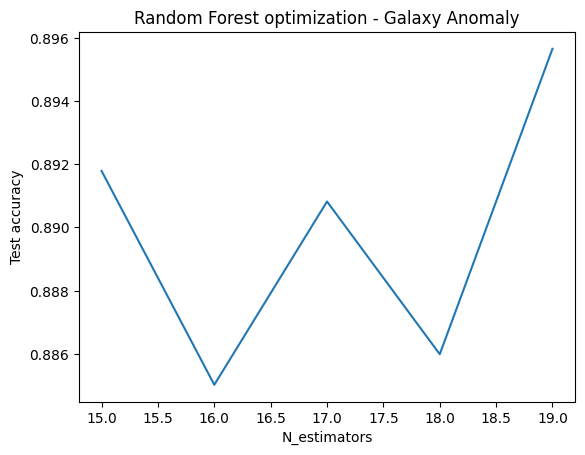

In [185]:
plt.plot(range(15,20), rf_acc)
plt.title('Random Forest optimization - Galaxy Anomaly')
plt.xlabel('N_estimators')
plt.ylabel('Test accuracy')
plt.show()

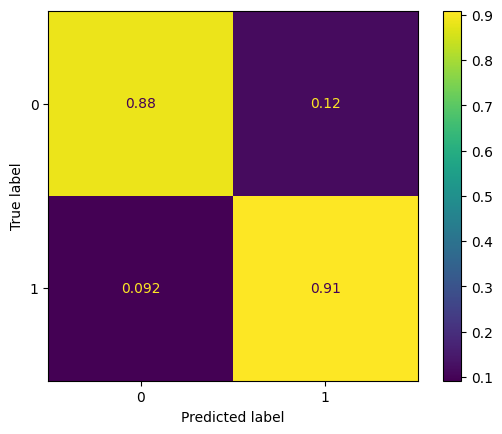

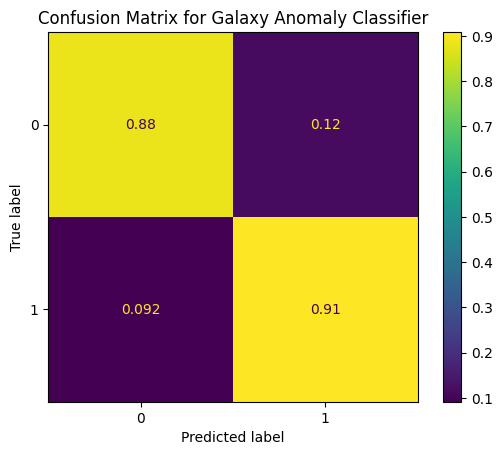

In [188]:
from sklearn.metrics import confusion_matrix
# Combine validation set back into training for final fit model
X_train = pd.concat([X_train, X_val])
y_train = pd.concat([y_train, y_val])
clf = rf(X_train, y_train, X_test, y_test, n_estimators= 19)[0]
y_pred = clf.predict(X_test)
vis = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true')
vis.plot()
plt.title('Confusion Matrix for Galaxy Anomaly Classifier')
plt.show()